In [426]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller,acf
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import OneHotEncoder as OHE,LabelEncoder as LE
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error as rmse , mean_absolute_error as mae , r2_score as r2,mean_absolute_percentage_error as mape
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.inspection import PartialDependenceDisplay

In [237]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [238]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Binance_BTCUSDT_d.csv',header=1)

In [239]:
df.shape

(3102, 10)

In [240]:
df.head()

,Unix,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,1771027200000,2026-02-14,BTCUSDT,68853.97,70560.01,68730.13,69822.95,18114.78393,1.260259e+09,3803163
1,1770940800000,2026-02-13,BTCUSDT,66272.17,69482.97,65872.46,68853.96,20244.54955,1.371286e+09,6450842
2,1770854400000,2026-02-12,BTCUSDT,67082.52,68410.52,65118.00,66272.17,24271.74283,1.622162e+09,6778280
3,1770768000000,2026-02-11,BTCUSDT,68841.28,69292.88,65756.00,67082.52,28718.24602,1.930514e+09,6956577
4,1770681600000,2026-02-10,BTCUSDT,70138.00,70527.59,67800.00,68841.29,20373.77072,1.408624e+09,4558658


In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unix         3102 non-null   int64  
 1   Date         3102 non-null   object 
 2   Symbol       3102 non-null   object 
 3   Open         3102 non-null   float64
 4   High         3102 non-null   float64
 5   Low          3102 non-null   float64
 6   Close        3102 non-null   float64
 7   Volume BTC   3102 non-null   float64
 8   Volume USDT  3102 non-null   float64
 9   tradecount   3102 non-null   int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 242.5+ KB


In [427]:
df.isna().sum()

,0
Unix,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume BTC,0
Volume USDT,0
tradecount,0
log_return,0


In [242]:
df['Date'] = pd.to_datetime(df['Date'])

In [243]:
df['Symbol'].nunique()

1

In [244]:
df = df.drop_duplicates(subset= 'Date')

In [ ]:
df.shape

(3102, 10)

In [245]:
df = df.sort_values('Date').reset_index(drop = True)

In [246]:
df['Date'].diff().value_counts().head()

,count
Date,
1 days,3099
2 days,2


In [247]:
df1 = df.copy()

In [248]:
full_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(),freq='D')
full_range.difference(df['Date'])

DatetimeIndex(['2026-01-08', '2026-01-20'], dtype='datetime64[ns]', freq=None)

In [249]:
df = df.drop('Symbol',axis=1)

<Axes: >

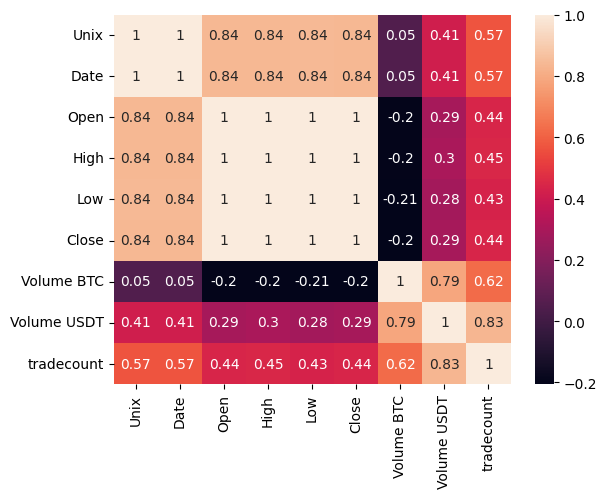

In [250]:
sns.heatmap(df.corr(),annot=True)

<Axes: >

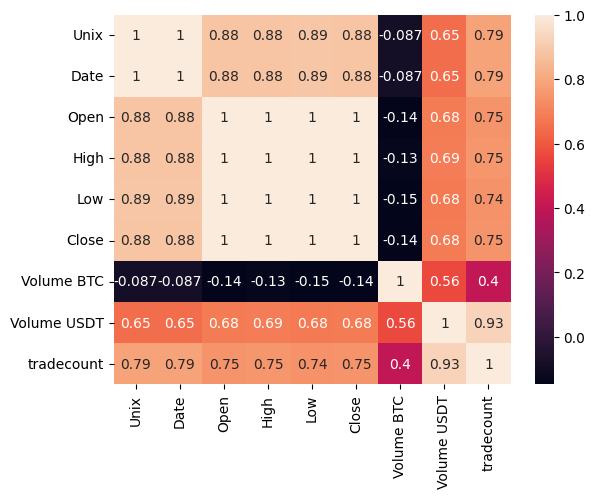

In [251]:
sns.heatmap(df.corr('spearman'),annot=True)

In [252]:
df['Date'].min(),df['Date'].max()

(Timestamp('2017-08-17 00:00:00'), Timestamp('2026-02-14 00:00:00'))

In [253]:
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
df = df.dropna()

In [254]:
train = df[df['Date'] < '2024-2-14']
test = df[df['Date'] >= '2024-2-14']

In [255]:
print(f'Train {train['Date'].min()} - {train['Date'].max()}')
print(f'Test {test['Date'].min()} - {test['Date'].max()}')

Train 2017-08-18 00:00:00 - 2024-02-13 00:00:00
Test 2024-02-14 00:00:00 - 2026-02-14 00:00:00


In [256]:
print(train.shape)

(2371, 10)


In [257]:
train.describe()

,Unix,Date,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount,log_return
count,2.371000e+03,2371,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,2.371000e+03,2.371000e+03,2371.000000
mean,1.605398e+12,2020-11-15 00:00:00,21315.788874,21863.382876,20714.196027,21335.004682,72717.547176,1.631076e+09,1.440596e+06,0.001034
min,1.503014e+12,2017-08-18 00:00:00,3188.010000,3276.500000,2817.000000,3189.020000,228.108068,9.778657e+05,2.153000e+03,-0.502607
25%,1.554206e+12,2019-04-02 12:00:00,8019.990000,8223.880000,7756.500000,8020.005000,29878.703280,2.852129e+08,3.028680e+05,-0.014568
50%,1.605398e+12,2020-11-15 00:00:00,16442.910000,16751.000000,15952.350000,16458.570000,46087.417751,7.824277e+08,7.948550e+05,0.000867
75%,1.656590e+12,2022-06-30 12:00:00,32111.255000,33299.390000,30595.135000,32161.420000,77208.060537,2.263781e+09,1.570538e+06,0.017357
max,1.707782e+12,2024-02-13 00:00:00,67525.820000,69000.000000,66222.400000,67525.830000,760705.362783,1.746531e+10,1.522359e+07,0.202952
std,5.914884e+10,NaN,16056.509160,16468.730786,15595.885806,16063.322027,83995.719111,2.038456e+09,1.978667e+06,0.038858


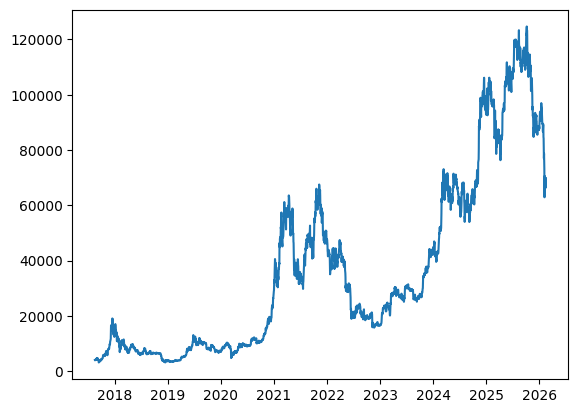

In [258]:
plt.plot(df['Date'].sort_values(),df['Close'])
plt.show()

In [259]:
scaler = StandardScaler()
train["log_return"] = scaler.fit_transform(train[["log_return"]])
test["log_return"]  = scaler.transform(test[["log_return"]])

/tmp/ipython-input-3268630675.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["log_return"] = scaler.fit_transform(train[["log_return"]])
/tmp/ipython-input-3268630675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["log_return"]  = scaler.transform(test[["log_return"]])


/tmp/ipython-input-1025317254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['day_of_week'] = train['Date'].dt.dayofweek


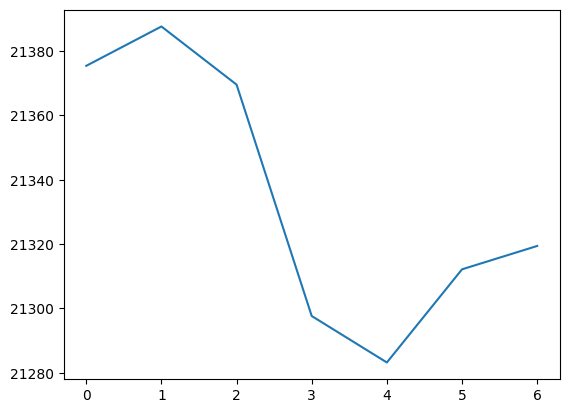

In [260]:
train['day_of_week'] = train['Date'].dt.dayofweek
seasonality = train.groupby('day_of_week')['Close'].mean()
plt.plot(seasonality.index,seasonality.values)

In [261]:
result = adfuller(train['Close'].dropna())
print('ADF : ',result[0])
print('p_value : ',result[1])

ADF :  -1.3362643492887671
p_value :  0.6124224185458967


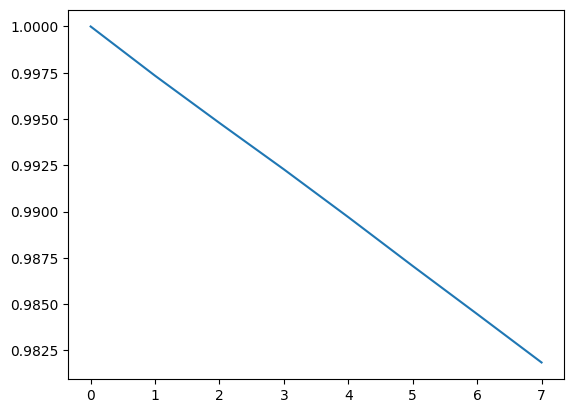

log1 :  0.9973403107999685


In [262]:
values = acf(train['Close'].dropna(),nlags=7)
plt.plot(values)
plt.show()
print('log1 : ',values[1])

In [263]:
print('log7 : ',values[7])

log7 :  0.9818516753920187


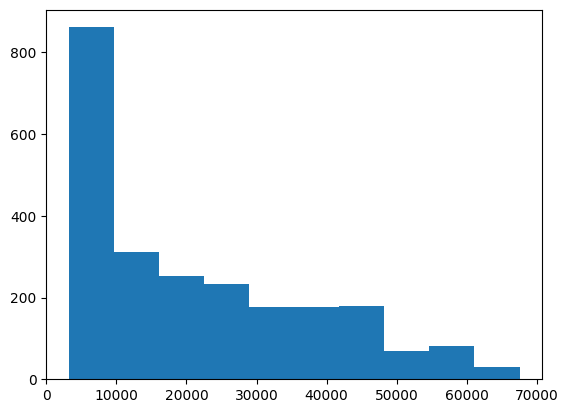

In [264]:
plt.hist(train['Close'].dropna())
plt.show()

In [265]:
first = train['Close'][:len(train)//2]
second = train['Close'][len(train)//2:]
print('Mean diff : ',abs(first.mean()-second.mean()))
diff = abs(first.mean() - second.mean())
pooled_std = train['Close'].std()
print(diff / pooled_std)

Mean diff :  26495.544734490297
1.6494436636575354


In [266]:
train['lag_1'] = train['Close'].shift(1)
train['lag_2'] = train['Close'].shift(2)
train['lag_3'] = train['Close'].shift(3)
train['lag_4'] = train['Close'].shift(4)
train['lag_5'] = train['Close'].shift(5)
train['lag_6'] = train['Close'].shift(6)
train['lag_7'] = train['Close'].shift(7)
test['lag_1'] = test['Close'].shift(1)
test['lag_2'] = test['Close'].shift(2)
test['lag_3'] = test['Close'].shift(3)
test['lag_4'] = test['Close'].shift(4)
test['lag_5'] = test['Close'].shift(5)
test['lag_6'] = test['Close'].shift(6)
test['lag_7'] = test['Close'].shift(7)

/tmp/ipython-input-459652453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['lag_1'] = train['Close'].shift(1)
/tmp/ipython-input-459652453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['lag_2'] = train['Close'].shift(2)
/tmp/ipython-input-459652453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [310]:
# feature engineering
train['Sample_return'] = (train['Close']/train['Close'].shift(1)) - 1
train['Overnight_return'] = (train['Open']/train['Close'].shift(1)) - 1
train['Intraday_return'] = (train['Open']/train['Close']) - 1
train['Hl_range'] = (train['High']-train['Low'])/train['Close'].shift(1)
train['Body_ratio'] = abs(train['Close']-train['Open'])/(train['High']-train['Low'])
train['Upper_shadow'] = train['High']-np.maximum(train['Open'],train['Close'])
train['Lower_shadow'] = np.minimum(train['Open'],train['Close'])-train['Low']
test['Sample_return'] = (test['Close']/test['Close'].shift(1)) - 1
test['Overnight_return'] = (test['Open']/test['Close'].shift(1)) - 1
test['Intraday_return'] = (test['Open']/test['Close']) - 1
test['Hl_range'] = (test['High']-test['Low'])/test['Close'].shift(1)
test['Body_ratio'] = abs(test['Close']-test['Open'])/(test['High']-test['Low'])
test['Upper_shadow'] = test['High']-np.maximum(test['Open'],test['Close'])
test['Lower_shadow'] = np.minimum(test['Open'],test['Close'])-test['Low']

In [311]:
train = train.dropna()
test = test.dropna()

In [269]:
train.shape

(2364, 25)

In [270]:
train_window_size = 3*365
val_window_size   = 1
step_size         = 1


train_start_idx = 0
train_end_idx   = train_start_idx + train_window_size
val_start_idx   = train_end_idx
val_end_idx     = val_start_idx + val_window_size

scaler = StandardScaler()
def rolling_window(train,train_start_idx,train_end_idx,val_start_idx,val_end_idx,model_e,model_params=None):
    rmse_scores = []
    mae_scores = []
    mape_scores = []
    while val_end_idx <= len(train):

        train_data = train.iloc[train_start_idx:train_end_idx].copy()
        val_data   = train.iloc[val_start_idx:val_end_idx].copy()
        train_data.ffill(inplace=True)
        val_data.ffill(inplace=True)
        cols_train = train_data.drop('Close',axis=1).select_dtypes(include='number').columns
        for col in cols_train:
            Q1 = train_data[col].quantile(0.01)
            Q3 = train_data[col].quantile(0.99)
            train_data[col] = train_data[col].clip(Q1,Q3)
            val_data[col] = val_data[col].clip(Q1,Q3)
        train_data[cols_train] = scaler.fit_transform(train_data[cols_train])
        val_data[cols_train] = scaler.transform(val_data[cols_train])
        train_data['Close_roll3'] = train_data['Close'].rolling(3,min_periods=1).mean()
        val_data['Close_roll3'] = val_data['Close'].rolling(3,min_periods=1).mean()
        train_data['Year'] = train_data['Date'].dt.year
        train_data['Month'] = train_data['Date'].dt.month
        val_data['Year'] = val_data['Date'].dt.year
        val_data['Month'] = val_data['Date'].dt.month
        train_data.dropna(inplace=True)
        val_data.dropna(inplace=True)

        X_train = train_data.drop(['Close','Date','Low','High'],axis=1)
        y_train = train_data['Close']

        X_val = val_data.drop(['Close','Date','Low','High'],axis=1)
        y_val = val_data['Close']
        if X_train.shape[0] == 0 or X_val.shape[0] == 0:
            break
        # مدل جدید در هر fold
        model = model_e(**model_params)
        model.fit(X_train, y_train)

        preds = model.predict(X_val)
        rmse1 = rmse(y_val, preds)
        mae1 = mae(y_val, preds)
        mape1 = mape(y_val, preds)
        rmse_scores.append(rmse1)
        mae_scores.append(mae1)
        mape_scores.append(mape1)
        # جلو بردن پنجره ثابت
        train_start_idx += step_size
        train_end_idx   += step_size
        val_start_idx   += step_size
        val_end_idx     += step_size
    return ((np.mean(rmse_scores),np.mean(mae_scores),np.mean(mape_scores)),(np.std(rmse_scores),np.std(mae_scores),np.std(mape_scores)))

In [271]:
model1 = LinearRegression()
model_params1 = {'fit_intercept':True}
score = rolling_window(train,train_start_idx,train_end_idx,val_start_idx,val_end_idx,model1,model_params1)

/tmp/ipython-input-747489903.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_data[col] = val_data[col].clip(Q1,Q3)
/tmp/ipython-input-747489903.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_data[col] = val_data[col].clip(Q1,Q3)
/tmp/ipython-input-747489903.py:29: FutureWarnin

In [272]:
score

((np.float64(1060.2280896517034),
  np.float64(1060.2280896517034),
  np.float64(0.03099972801192794)),
 (np.float64(1216.8351816722798),
  np.float64(1216.8351816722798),
  np.float64(0.03290115948733665)))

In [273]:
error_rmse1 = score[0][0]/train['Close'].mean()
error_rmse1

np.float64(0.04957582944861686)

In [274]:
model2 = RandomForestRegressor()
model_params2 = {'n_estimators':100,'max_depth':5,'min_samples_split':10,'max_features':'sqrt','bootstrap':True}
score2 = rolling_window(train,train_start_idx,train_end_idx,val_start_idx,val_end_idx,model2,model_params2)

/tmp/ipython-input-747489903.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_data[col] = val_data[col].clip(Q1,Q3)
/tmp/ipython-input-747489903.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_data[col] = val_data[col].clip(Q1,Q3)
/tmp/ipython-input-747489903.py:29: FutureWarnin

In [275]:
score2

((np.float64(1069.6851076821072),
  np.float64(1069.6851076821072),
  np.float64(0.03216287601113731)),
 (np.float64(1276.161756600893),
  np.float64(1276.161756600893),
  np.float64(0.03413461422490438)))

In [276]:
error_rmse2 = score2[0][0]/train['Close'].mean()
error_rmse2

np.float64(0.050018035722477996)

In [277]:
model3 = XGBRegressor()
model_params3 = {'n_estimators':100,'learning_rate':0.01,'max_depth':5,'min_child_weight':5,'subsample':0.8}
score3 = rolling_window(train,train_start_idx,train_end_idx,val_start_idx,val_end_idx,model3,model_params3)

/tmp/ipython-input-747489903.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_data[col] = val_data[col].clip(Q1,Q3)
/tmp/ipython-input-747489903.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_data[col] = val_data[col].clip(Q1,Q3)
/tmp/ipython-input-747489903.py:29: FutureWarnin

In [278]:
score3

((np.float64(5816.13643204541),
  np.float64(5816.13643204541),
  np.float64(0.15940840387043712)),
 (np.float64(5509.171302767904),
  np.float64(5509.171302767904),
  np.float64(0.10193916014123416)))

In [279]:
error_rmse3 = score3[0][0]/train['Close'].mean()
error_rmse3

np.float64(0.2719601476505806)

In [284]:
model4 = CatBoostRegressor()
model_params4 = {'iterations':200,'learning_rate':0.01,'depth':6,'l2_leaf_reg':7,'border_count':32,'random_strength':1.0}
score4 = rolling_window(train,train_start_idx,train_end_idx,val_start_idx,val_end_idx,model4,model_params4)

Streaming output truncated to the last 5000 lines.
63:	learn: 1635.0633792	total: 72.6ms	remaining: 154ms
64:	learn: 1622.3518348	total: 73.7ms	remaining: 153ms
65:	learn: 1609.7507426	total: 75.2ms	remaining: 153ms
66:	learn: 1596.9694692	total: 76.4ms	remaining: 152ms
67:	learn: 1584.6692145	total: 77.6ms	remaining: 151ms
68:	learn: 1573.1620890	total: 78.7ms	remaining: 149ms
69:	learn: 1562.4749817	total: 80.1ms	remaining: 149ms
70:	learn: 1550.4684054	total: 81.5ms	remaining: 148ms
71:	learn: 1539.1723492	total: 82.7ms	remaining: 147ms
72:	learn: 1528.3604454	total: 83.9ms	remaining: 146ms
73:	learn: 1518.5870563	total: 85.1ms	remaining: 145ms
74:	learn: 1507.6374531	total: 86.2ms	remaining: 144ms
75:	learn: 1496.3476867	total: 87.7ms	remaining: 143ms
76:	learn: 1485.9031957	total: 88.9ms	remaining: 142ms
77:	learn: 1475.5220116	total: 90ms	remaining: 141ms
78:	learn: 1465.3523231	total: 91.2ms	remaining: 140ms
79:	learn: 1454.4843985	total: 92.3ms	remaining: 139ms
80:	learn: 1443.

/tmp/ipython-input-747489903.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_data[col] = val_data[col].clip(Q1,Q3)


Streaming output truncated to the last 5000 lines.
0:	learn: 3453.6728363	total: 1.29ms	remaining: 258ms
1:	learn: 3428.5227488	total: 2.41ms	remaining: 239ms
2:	learn: 3401.3407480	total: 3.51ms	remaining: 230ms
3:	learn: 3374.1161899	total: 4.58ms	remaining: 224ms
4:	learn: 3348.7439223	total: 5.65ms	remaining: 220ms
5:	learn: 3322.1196990	total: 6.71ms	remaining: 217ms
6:	learn: 3295.5383972	total: 7.78ms	remaining: 215ms
7:	learn: 3270.4608333	total: 8.87ms	remaining: 213ms
8:	learn: 3244.2345805	total: 9.96ms	remaining: 211ms
9:	learn: 3218.2657754	total: 11ms	remaining: 209ms
10:	learn: 3193.2661564	total: 12ms	remaining: 207ms
11:	learn: 3167.8845007	total: 13.1ms	remaining: 205ms
12:	learn: 3142.1291284	total: 14.1ms	remaining: 203ms
13:	learn: 3117.6333564	total: 15.2ms	remaining: 201ms
14:	learn: 3097.6559278	total: 16.3ms	remaining: 201ms
15:	learn: 3073.9348393	total: 17.4ms	remaining: 200ms
16:	learn: 3051.2935001	total: 18.4ms	remaining: 199ms
17:	learn: 3029.4024267	tota

/tmp/ipython-input-747489903.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_data[col] = val_data[col].clip(Q1,Q3)


Streaming output truncated to the last 5000 lines.
41:	learn: 12398.9237872	total: 60ms	remaining: 226ms
42:	learn: 12299.5559541	total: 61.1ms	remaining: 223ms
43:	learn: 12192.5927754	total: 62.2ms	remaining: 220ms
44:	learn: 12087.3600451	total: 63.3ms	remaining: 218ms
45:	learn: 11980.9670822	total: 64.3ms	remaining: 215ms
46:	learn: 11873.5777686	total: 65.4ms	remaining: 213ms
47:	learn: 11773.3792444	total: 66.4ms	remaining: 210ms
48:	learn: 11672.8868666	total: 67.4ms	remaining: 208ms
49:	learn: 11580.8004557	total: 68.5ms	remaining: 205ms
50:	learn: 11479.1166081	total: 69.5ms	remaining: 203ms
51:	learn: 11377.7146058	total: 70.6ms	remaining: 201ms
52:	learn: 11276.5693820	total: 71.6ms	remaining: 199ms
53:	learn: 11178.2153059	total: 72.7ms	remaining: 196ms
54:	learn: 11079.7536164	total: 73.7ms	remaining: 194ms
55:	learn: 10986.9185042	total: 74.7ms	remaining: 192ms
56:	learn: 10896.1686097	total: 75.7ms	remaining: 190ms
57:	learn: 10801.2940660	total: 76.8ms	remaining: 188ms

/tmp/ipython-input-747489903.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_data[col] = val_data[col].clip(Q1,Q3)


Streaming output truncated to the last 5000 lines.
0:	learn: 12481.4759777	total: 4.19ms	remaining: 833ms
1:	learn: 12385.6639230	total: 6.51ms	remaining: 645ms
2:	learn: 12284.5893705	total: 12.3ms	remaining: 808ms
3:	learn: 12178.9108610	total: 15.2ms	remaining: 743ms
4:	learn: 12082.6098874	total: 18.2ms	remaining: 709ms
5:	learn: 11987.5883131	total: 21ms	remaining: 678ms
6:	learn: 11890.2031790	total: 24.1ms	remaining: 663ms
7:	learn: 11791.7632975	total: 25.9ms	remaining: 621ms
8:	learn: 11688.1705546	total: 30ms	remaining: 636ms
9:	learn: 11589.3619225	total: 33.4ms	remaining: 635ms
10:	learn: 11497.2030132	total: 37.5ms	remaining: 644ms
11:	learn: 11408.4139937	total: 40.8ms	remaining: 640ms
12:	learn: 11310.1364942	total: 44.8ms	remaining: 645ms
13:	learn: 11221.2015132	total: 48.2ms	remaining: 640ms
14:	learn: 11133.3260873	total: 53.2ms	remaining: 656ms
15:	learn: 11043.6827533	total: 56.4ms	remaining: 649ms
16:	learn: 10949.8711597	total: 58.3ms	remaining: 627ms
17:	learn: 

In [285]:
score4

((np.float64(3467.8600040508163),
  np.float64(3467.8600040508163),
  np.float64(0.09692294035059587)),
 (np.float64(3959.988602600795),
  np.float64(3959.988602600795),
  np.float64(0.08400370971497631)))

In [286]:
error_rmse4 = score4[0][0]/train['Close'].mean()
error_rmse4

np.float64(0.16215570761663306)

In [428]:
data = {'model': ['LinearRegression','RandomForestClassifier','XGBClassifier','CatBoostClassifier'],'error_rmse': [error_rmse1,error_rmse2,error_rmse3,error_rmse4],'mape':[score[0][1],score2[0][1],score3[0][1],score4[0][1]],'mae':[score[0][2],score2[0][2],score3[0][2],score4[0][2]]}


In [282]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.8 MB/s eta 0:00:00


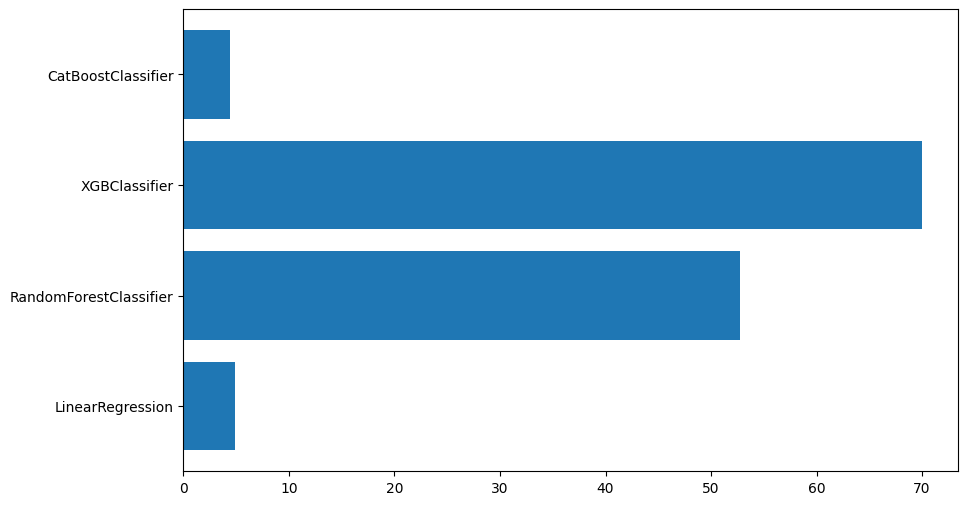

In [429]:
plt.figure(figsize=(10, 6))
plt.barh(data['model'], data['error_rmse'], label='Train')
plt.show()

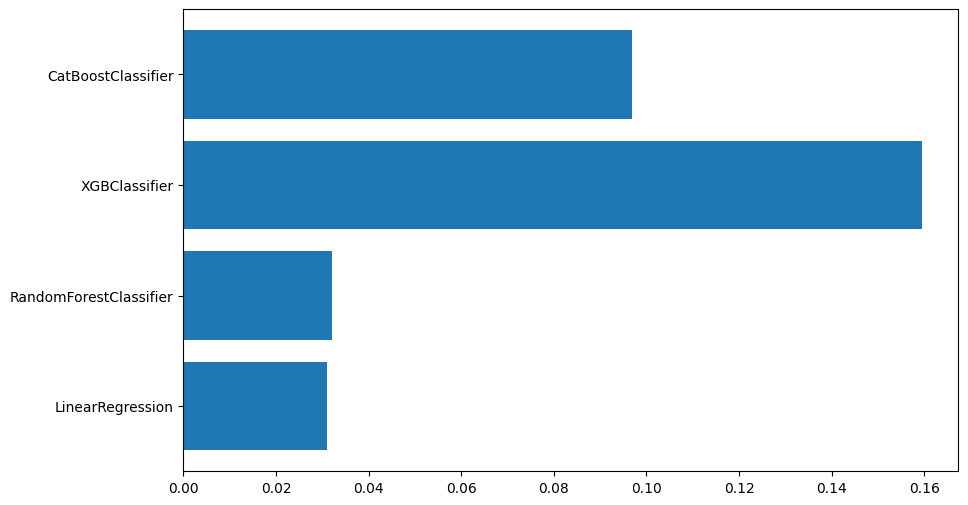

In [430]:
plt.figure(figsize=(10, 6))
plt.barh(data['model'], data['mae'], label='Train')
plt.show()

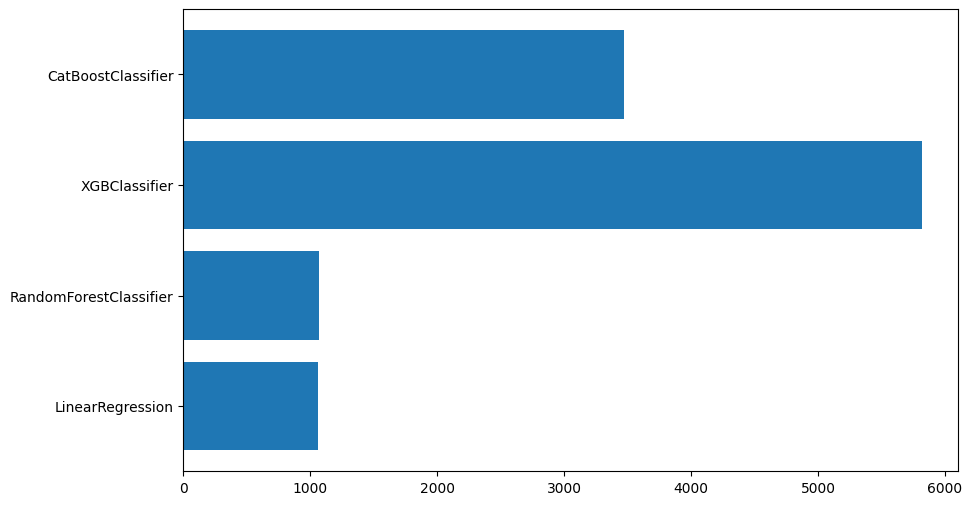

In [431]:
plt.figure(figsize=(10, 6))
plt.barh(data['model'], data['mape'], label='Train')
plt.show()

In [312]:
test['day_of_week'] = test['Date'].dt.dayofweek

In [320]:
test.drop('Bpody_ratio',axis=1,inplace = True)

In [343]:
train['Target'] = train['Close'].shift(-1)
test['Target'] = test['Close'].shift(-1)
train = train.dropna()
test = test.dropna()

In [362]:
cols[:-1]

Index(['Unix', 'Open', 'High', 'Low', 'Close', 'Volume BTC', 'Volume USDT',
       'tradecount', 'log_return', 'day_of_week', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_6', 'lag_7', 'Sample_return', 'Overnight_return',
       'Intraday_return', 'Hl_range', 'Body_ratio', 'Upper_shadow',
       'Lower_shadow', 'Year', 'Month'],
      dtype='object')

In [389]:
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month

cols = train.select_dtypes(include=[np.number]).columns
train[['Unix', 'Open', 'High', 'Low', 'Volume BTC', 'Volume USDT','tradecount', 'log_return', 'day_of_week', 'lag_1', 'lag_2', 'lag_3','lag_4', 'lag_5', 'lag_6', 'lag_7', 'Sample_return', 'Overnight_return','Intraday_return', 'Hl_range', 'Body_ratio', 'Upper_shadow','Lower_shadow', 'Year', 'Month']] = scaler.fit_transform(train[['Unix', 'Open', 'High', 'Low', 'Volume BTC', 'Volume USDT','tradecount', 'log_return', 'day_of_week', 'lag_1', 'lag_2', 'lag_3','lag_4', 'lag_5', 'lag_6', 'lag_7', 'Sample_return', 'Overnight_return','Intraday_return', 'Hl_range', 'Body_ratio', 'Upper_shadow','Lower_shadow', 'Year', 'Month']])
test[['Unix', 'Open', 'High', 'Low', 'Volume BTC', 'Volume USDT','tradecount', 'log_return', 'day_of_week', 'lag_1', 'lag_2', 'lag_3','lag_4', 'lag_5', 'lag_6', 'lag_7', 'Sample_return', 'Overnight_return','Intraday_return', 'Hl_range', 'Body_ratio', 'Upper_shadow','Lower_shadow', 'Year', 'Month']] = scaler.transform(test[['Unix', 'Open', 'High', 'Low', 'Volume BTC', 'Volume USDT','tradecount', 'log_return', 'day_of_week', 'lag_1', 'lag_2', 'lag_3','lag_4', 'lag_5', 'lag_6', 'lag_7', 'Sample_return', 'Overnight_return','Intraday_return', 'Hl_range', 'Body_ratio', 'Upper_shadow','Lower_shadow', 'Year', 'Month']])

X_train_full = train.drop(['Close','Date','Low','High','Target'], axis=1)
y_train_full = train['Target']


final_model1 = LinearRegression(**model_params1)
final_model1.fit(X_train_full, y_train_full)
test = test[train.columns]
X_test = test.drop(['Close','Date','Low','High','Target'], axis=1)

y_test = test['Target']
preds_test = final_model1.predict(X_test)

rmse_test1 = rmse(y_test, preds_test)
mae_test1 = mae(y_test, preds_test)
mape_test1 = mape(y_test, preds_test)
error_rmse1 = (rmse_test1/y_test.mean())*100


In [390]:
X_train_full = train.drop(['Close','Date','Low','High','Target'], axis=1)
y_train_full = train['Target']

train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month

final_model2 = RandomForestRegressor(**model_params2)
final_model2.fit(X_train_full, y_train_full)

X_test = test.drop(['Close','Date','Low','High','Target'], axis=1)
y_test = test['Target']
preds_test = final_model2.predict(X_test)

rmse_test2 = rmse(y_test, preds_test)
mae_test2 = mae(y_test, preds_test)
mape_test2 = mape(y_test, preds_test)
error_rmse2 = (rmse_test2/y_test.mean())*100


In [391]:
X_train_full = train.drop(['Close','Date','Low','High','Target'], axis=1)
y_train_full = train['Target']

train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month

final_model3 = XGBRegressor(**model_params3)
final_model3.fit(X_train_full, y_train_full)

X_test = test.drop(['Close','Date','Low','High','Target'], axis=1)
y_test = test['Target']
preds_test = final_model3.predict(X_test)

rmse_test3 = rmse(y_test, preds_test)
mae_test3 = mae(y_test, preds_test)
mape_test3 = mape(y_test, preds_test)
error_rmse3 = (rmse_test3/y_test.mean())*100


In [392]:
X_train_full = train.drop(['Close','Date','Low','High','Target'], axis=1)
y_train_full = train['Target']

train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month

final_model4 = CatBoostRegressor(**model_params4)
final_model4.fit(X_train_full, y_train_full)

X_test = test.drop(['Close','Date','Low','High','Target'], axis=1)
y_test = test['Target']
preds_test = final_model4.predict(X_test)

rmse_test4 = rmse(y_test, preds_test)
mae_test4 = mae(y_test, preds_test)
mape_test4 = mape(y_test, preds_test)
error_rmse4 = (rmse_test4/y_test.mean())*100


0:	learn: 0.9910087	total: 2.04ms	remaining: 405ms
1:	learn: 0.9822714	total: 3.83ms	remaining: 379ms
2:	learn: 0.9735796	total: 5.22ms	remaining: 343ms
3:	learn: 0.9649385	total: 6.65ms	remaining: 326ms
4:	learn: 0.9565065	total: 7.97ms	remaining: 311ms
5:	learn: 0.9478934	total: 8.8ms	remaining: 285ms
6:	learn: 0.9395299	total: 10.4ms	remaining: 286ms
7:	learn: 0.9318729	total: 11.8ms	remaining: 283ms
8:	learn: 0.9236309	total: 13ms	remaining: 277ms
9:	learn: 0.9153223	total: 14.4ms	remaining: 273ms
10:	learn: 0.9070248	total: 15.8ms	remaining: 272ms
11:	learn: 0.8989737	total: 17.2ms	remaining: 270ms
12:	learn: 0.8906511	total: 18.5ms	remaining: 267ms
13:	learn: 0.8825187	total: 20.1ms	remaining: 267ms
14:	learn: 0.8749428	total: 21.6ms	remaining: 266ms
15:	learn: 0.8671780	total: 23ms	remaining: 264ms
16:	learn: 0.8593660	total: 24.3ms	remaining: 262ms
17:	learn: 0.8518399	total: 25.7ms	remaining: 259ms
18:	learn: 0.8439266	total: 27ms	remaining: 257ms
19:	learn: 0.8362155	total: 2

In [432]:
data_finall = {'model': ['LinearRegression','RandomForestClassifier','XGBClassifier','CatBoostClassifier'],'error_rmse': [error_rmse1,error_rmse2,error_rmse3,error_rmse4],'mape':[mape_test1,mape_test2,mape_test3,mape_test4],'mae':[mae_test1,mae_test2,mae_test3,mae_test4]}

In [394]:
test.columns

Index(['Unix', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume BTC',
       'Volume USDT', 'tradecount', 'log_return', 'day_of_week', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'Sample_return',
       'Overnight_return', 'Intraday_return', 'Hl_range', 'Body_ratio',
       'Upper_shadow', 'Lower_shadow', 'Year', 'Month', 'Target'],
      dtype='object')

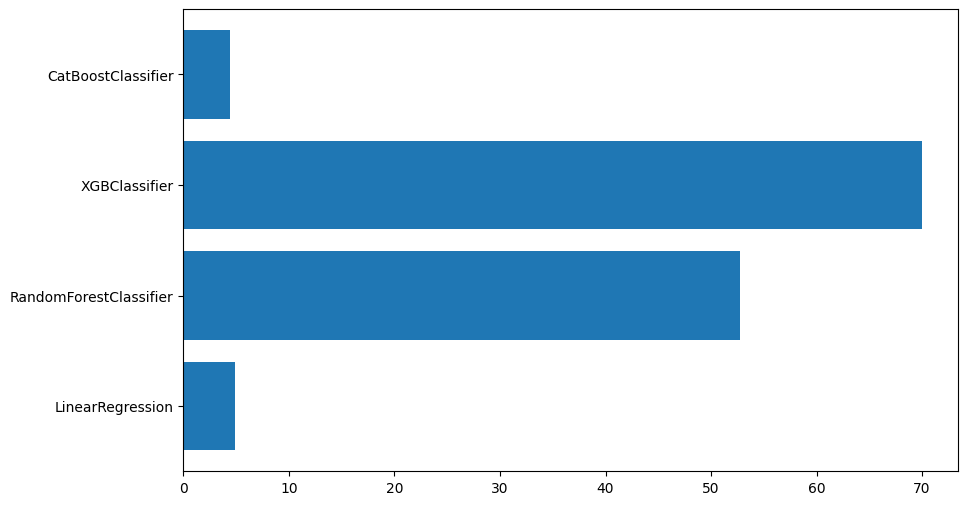

In [435]:
plt.figure(figsize=(10, 6))
plt.barh(data_finall['model'], data_finall['error_rmse'], label='Train')
plt.show()

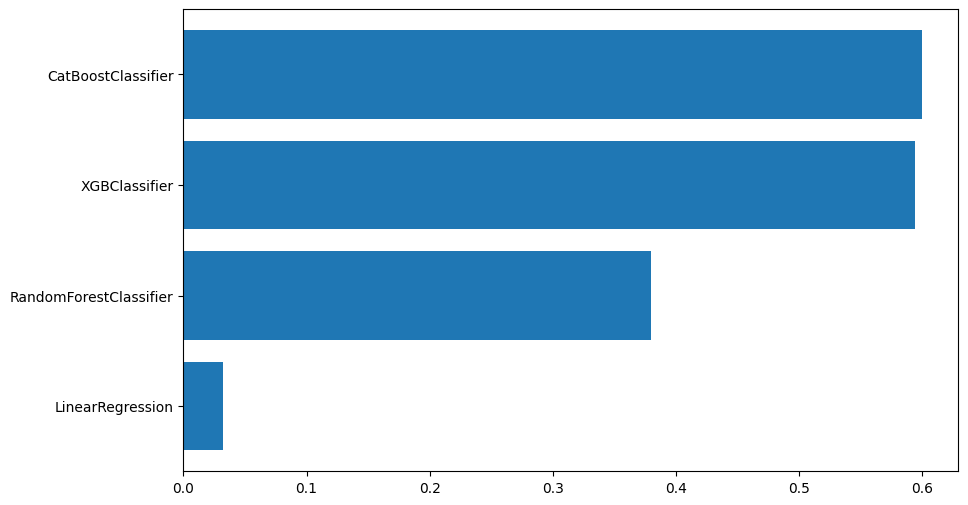

In [434]:
plt.figure(figsize=(10, 6))
plt.barh(data_finall['model'], data_finall['mape'], label='Train')
plt.show()

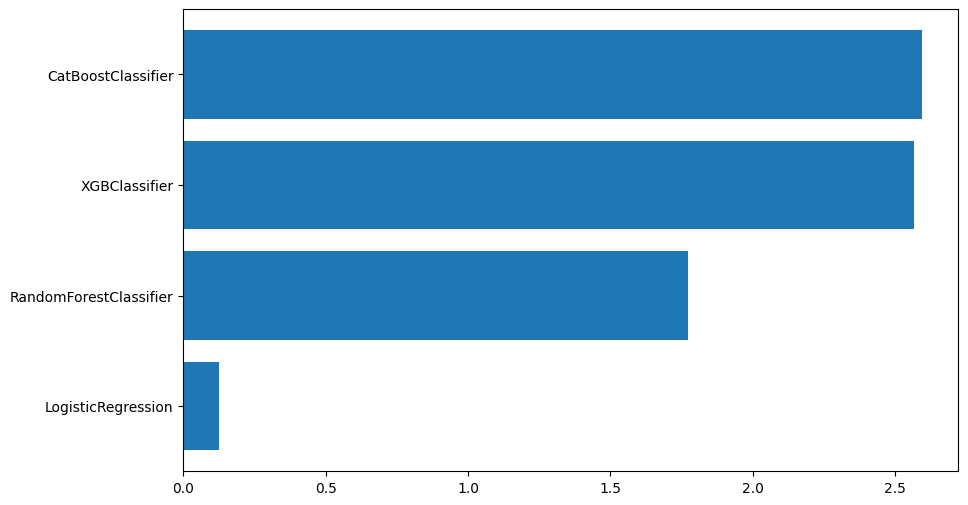

In [397]:
plt.figure(figsize=(10, 6))
plt.barh(data_finall['model'], data_finall['mae'], label='Train')
plt.show()

In [398]:
X_train_simple = train[['lag_1']]
y_train = train['Close']

model = LinearRegression()
model.fit(X_train_simple, y_train)

X_test_simple = test[['lag_1']]
pred = model.predict(X_test_simple)
rmse_test4 = rmse(y_test, pred)
error_rmse4 = (rmse_test4/y_test.mean())*100


In [399]:
error_rmse4

np.float64(4.412404385358845)

In [408]:
exp = shap.Explainer(final_model1,X_train_full)

In [409]:
values = exp(X_test)

/tmp/ipython-input-2128949337.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(values,X_test)


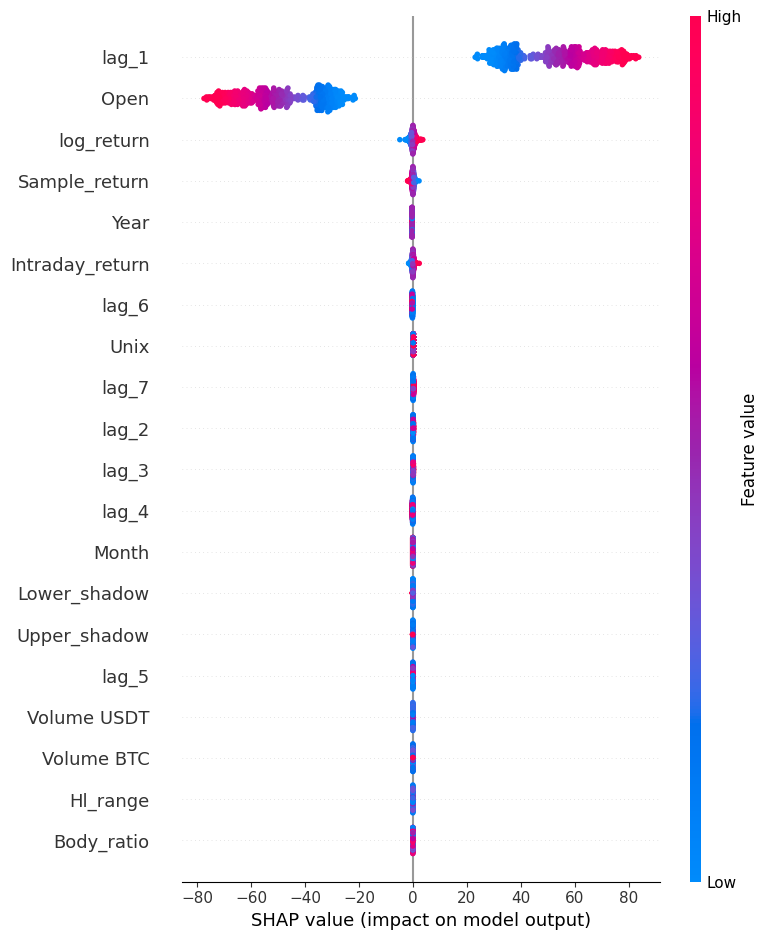

In [411]:
shap.summary_plot(values,X_test)
plt.show()

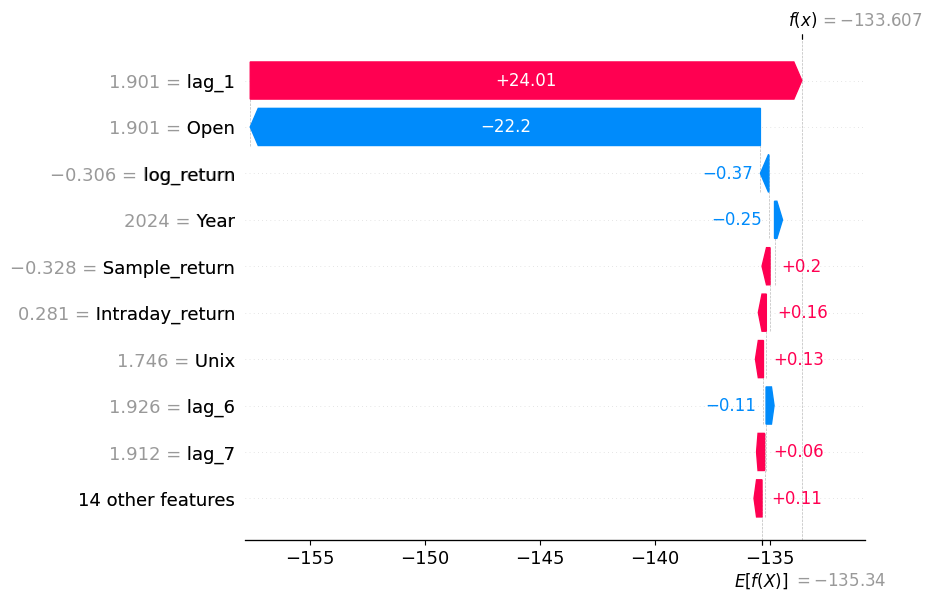

In [412]:
shap.plots.waterfall(values[0])
plt.show()

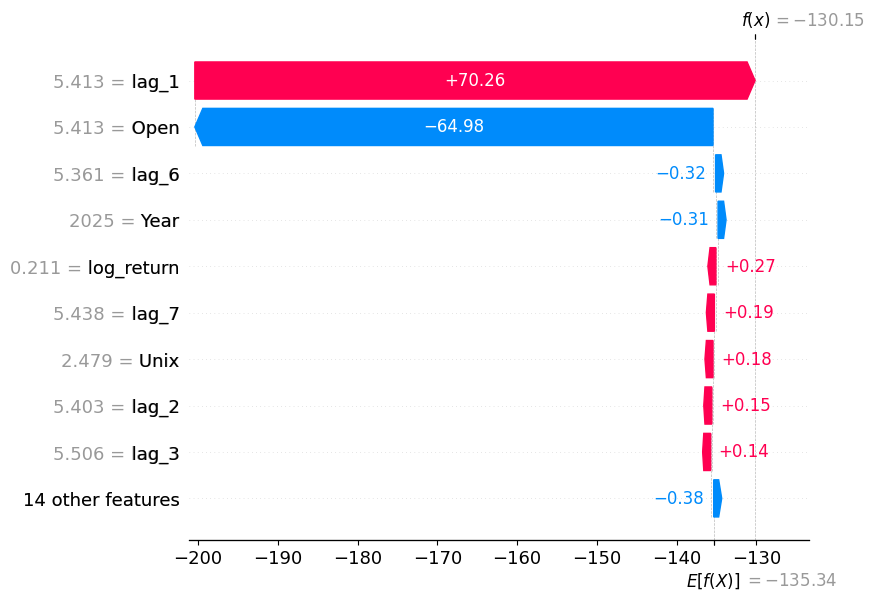

In [414]:
shap.plots.waterfall(values[500])
plt.show()

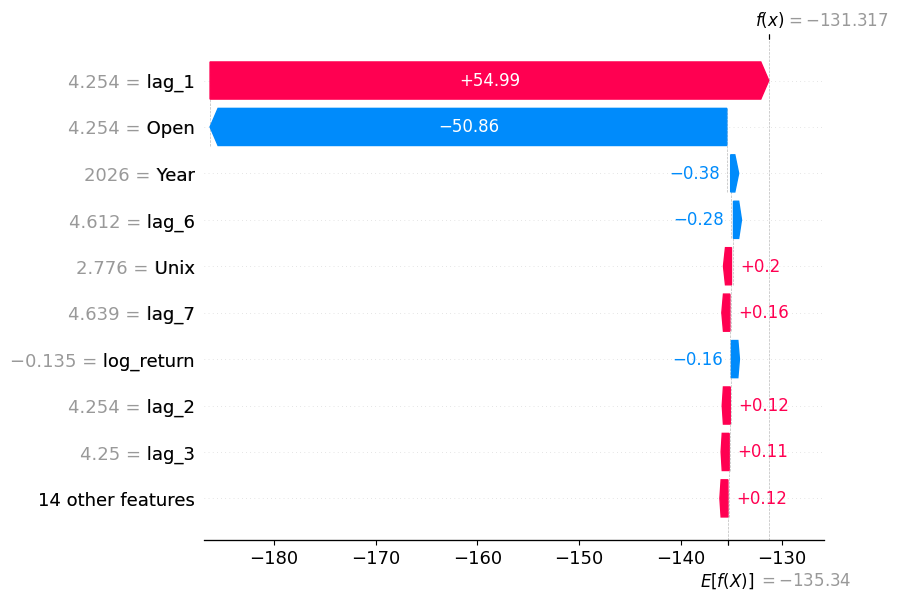

In [416]:
shap.plots.waterfall(values[700])
plt.show()

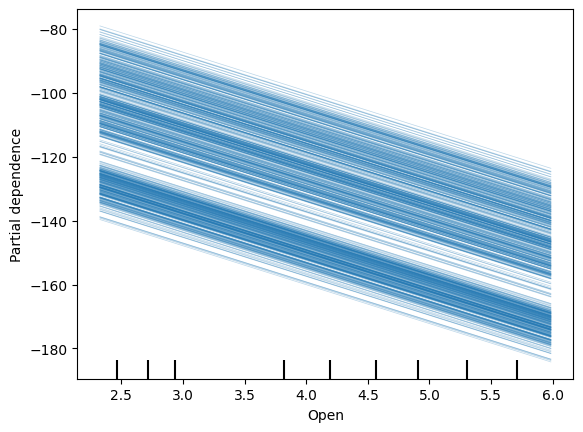

In [417]:
new_var = PartialDependenceDisplay.from_estimator(final_model1,X_test,features=['Open'],kind='individual')
new_var
plt.show()

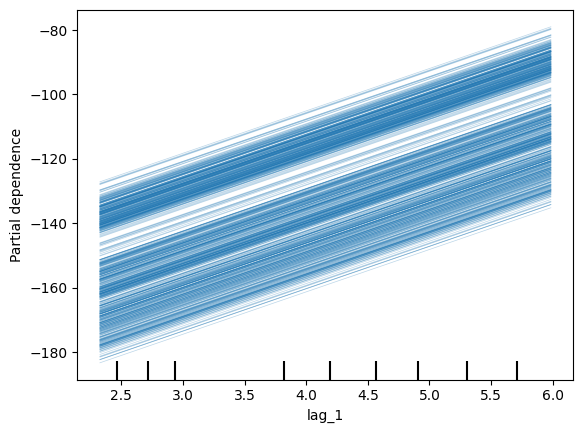

In [419]:
new_var = PartialDependenceDisplay.from_estimator(final_model1,X_test,features=['lag_1'],kind='individual')
new_var
plt.show()

In [420]:
def calculate_vif(X):
  vif_data = pd.DataFrame()
  vif_data['feature'] = X.columns
  vif_data['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
  return vif_data.sort_values(by='VIF',ascending=False).round(2)

In [422]:
vif = calculate_vif(pd.concat([X_train_full,X_test],axis=0))
vif

,feature,VIF
7,lag_1,822928.18
1,Open,821803.63
5,log_return,58453.27
14,Sample_return,18991.04
16,Intraday_return,11071.88
8,lag_2,1448.31
10,lag_4,1441.31
11,lag_5,1441.23
12,lag_6,1440.38
9,lag_3,1439.97


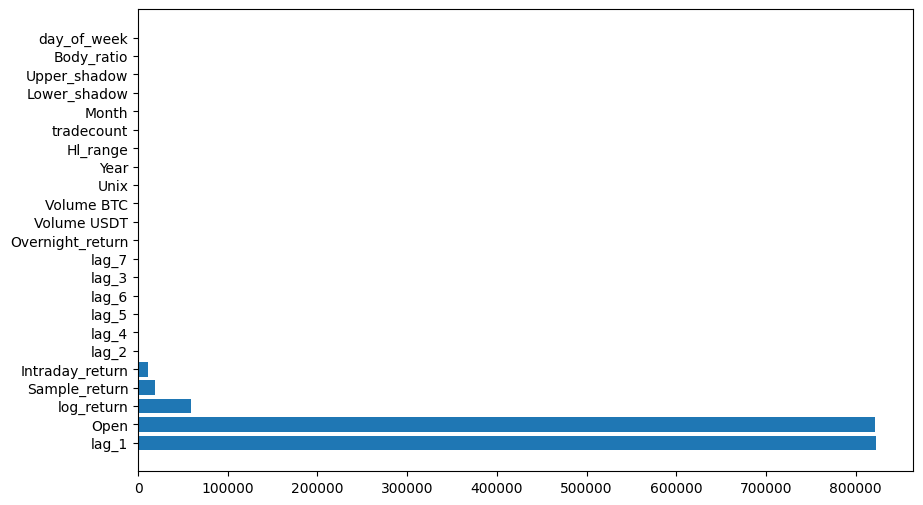

In [423]:
plt.figure(figsize=(10, 6))
plt.barh(vif['feature'], vif['VIF'], label='Train')
plt.show()

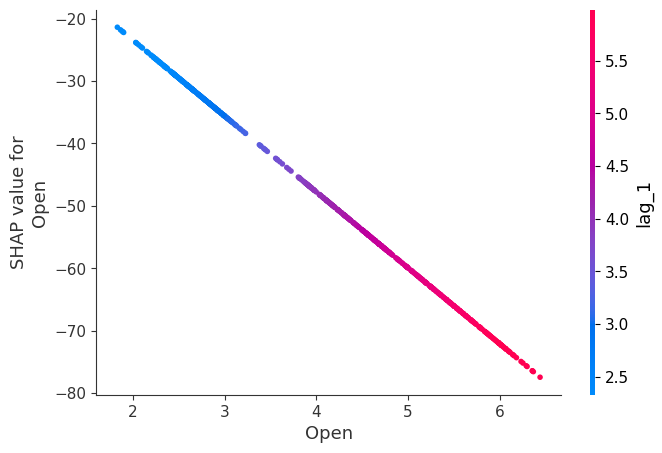

In [424]:
new_var0 = shap.dependence_plot('Open',values.values,X_test)
new_var0